In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import GFN_model


dim=2
hidden=[16,64,64,16,dim]
test_x1 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),2,axis=1)
test_x1 = torch.tensor(test_x1).float()
test_x1[:,1]=0.1
test_x2 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),2,axis=1)
test_x2 = torch.tensor(test_x2).float()
test_x2[:,1]=0.2
test_x3 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),2,axis=1)
test_x3 = torch.tensor(test_x3).float()
test_x3[:,1]=0.3
true_f = lambda u: u[:,0] - u[:,0]**3 - 5e-3 - u[:,1]
true_g = lambda u: u[:,0]-u[:,1]
num = 24
para1_mat = np.ndarray((num,50))
para2_mat = np.ndarray((num,50))
nonpara1_mat = np.ndarray((num,1001,50))
nonpara2_mat = np.ndarray((num,1001,50))
nonpara3_mat = np.ndarray((num,1001,50))
u_mat = np.ndarray((num,50))
settings = 0
sample_size_list = np.ndarray((num))
for ss in [3,4,5,6,7,8]:
    for ts in [5,10,20,50]:
        for i in range(50):
            checkpoints = torch.load('checkpoint_para/ckpt_gfn_64_16_%d_0.100_0.001_0.005_%d_%d.pth'%(ts,ss,i))
            model_net = GFN_model.NonParametricModel(state_dim=dim,hidden=hidden)
            model_net.net.load_state_dict(checkpoints['net'])
            para1_mat[settings,i] = checkpoints['D_1'].to('cpu').detach().numpy()
            para2_mat[settings,i] = checkpoints['D_2'].to('cpu').detach().numpy()
            non_out1 = model_net.net(test_x1)
            nonpara1_mat[settings,:,i] = (non_out1[:,0].reshape(-1).detach() - true_f(test_x1)).numpy()
            non_out2 = model_net.net(test_x2)
            nonpara2_mat[settings,:,i] = (non_out2[:,0].reshape(-1).detach() - true_f(test_x2)).numpy()
            non_out3 = model_net.net(test_x3)
            nonpara3_mat[settings,:,i] = (non_out3[:,0].reshape(-1).detach() - true_f(test_x3)).numpy()
            u_mat[settings,i] = checkpoints['u_loss']
            sample_size_list[settings] = ss*ss*ts
        settings = settings + 1
bias1 = np.mean(para1_mat,axis=1) - 1e-3
std1 = np.sqrt(np.mean(np.square(para1_mat - np.mean(para1_mat,axis=1,keepdims=True)),axis=1))
rmse1 = np.sqrt(bias1**2 + std1**2)
bias2 = np.mean(para2_mat,axis=1) - 5e-3
std2 = np.sqrt(np.mean(np.square(para2_mat - np.mean(para2_mat,axis=1,keepdims=True)),axis=1))
rmse2 = np.sqrt(bias2**2 + std2**2)
bias1_non = np.sqrt(np.mean(np.square(np.mean(nonpara1_mat,axis=2)),axis=1))
std1_non = np.sqrt(np.mean(np.square(nonpara1_mat -np.mean(nonpara1_mat,axis=2,keepdims=True)),axis=(1,2)))
rmse1_non = np.sqrt(bias1_non**2 + std1_non**2)
bias2_non = np.sqrt(np.mean(np.square(np.mean(nonpara2_mat,axis=2)),axis=1))
std2_non = np.sqrt(np.mean(np.square(nonpara2_mat -np.mean(nonpara2_mat,axis=2,keepdims=True)),axis=(1,2)))
rmse2_non = np.sqrt(bias2_non**2 + std2_non**2)
bias3_non = np.sqrt(np.mean(np.square(np.mean(nonpara3_mat,axis=2)),axis=1))
std3_non = np.sqrt(np.mean(np.square(nonpara3_mat -np.mean(nonpara3_mat,axis=2,keepdims=True)),axis=(1,2)))
rmse3_non = np.sqrt(bias3_non**2 + std3_non**2)
rmse_non = np.sqrt((np.square(rmse1_non) + np.square(rmse2_non) + np.square(rmse3_non))/3)
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
print(sample_size_list)
print(rmse1)
print(rmse2)
print(rmse_non)
print(rmse_u)
# np.savez('outputs/gfn_para_results.npz',rmse1=rmse1,rmse2=rmse2,rmse_non = rmse_non,rmse_u=rmse_u,sample_size_list=sample_size_list)

/tmp/ipykernel_206149/506513724.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint_para/ckpt_gfn_64_16_%d_0.100_0.001_0.005_%d_%d.pth'

KeyboardInterrupt: 

[[-0.23142474]] [-3.10925102]
[[-0.37024885]] [-2.91902151]


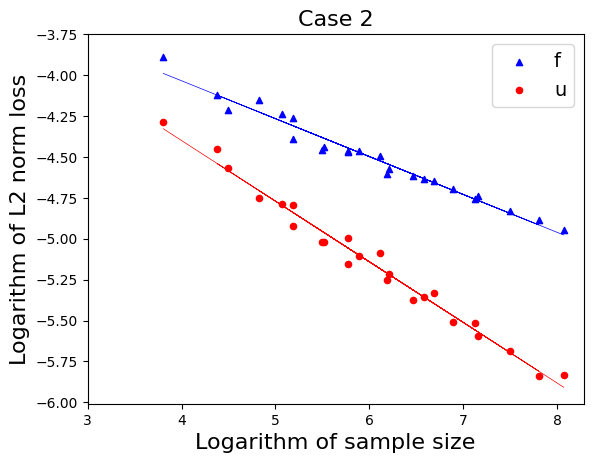

In [ ]:
from sklearn.linear_model import LinearRegression
data = np.load('outputs/gfn_para_results.npz')
rmse_non = data['rmse_non']
rmse_u = data['rmse_u']
sample_size_list = data['sample_size_list']
x1 = np.log(sample_size_list)
y1 = np.log(rmse_non)
regressor1 = LinearRegression()
regressor1 = regressor1.fit(np.reshape(x1,(-1, 1)),np.reshape(y1,(-1, 1)))
print(regressor1.coef_, regressor1.intercept_)  
plt.scatter(x1,y1,s=20,c='b',marker='^')
# plt.xlim((3,8))
# plt.ylim((-6,-4.5))
x2 = np.log(sample_size_list)
y2 = np.log(rmse_u)
regressor2 = LinearRegression()
regressor2 = regressor2.fit(np.reshape(x2,(-1, 1)),np.reshape(y2,(-1, 1)))
print(regressor2.coef_, regressor2.intercept_) 
plt.scatter(x2,y2,s=20,c='r')
plt.plot(np.reshape(x1,(-1,1)), regressor1.predict(np.reshape(x1,(-1,1))),'-b',linewidth=0.5)
# plt.annotate(r'slope =$%.3f$' % regressor1.coef_[0][0], c='b', xy=(6, 6*regressor1.coef_ + regressor1.intercept_),
#             xycoords='data', xytext=(+30, +20),
#             textcoords='offset points', fontsize=12,
#             arrowprops=dict(arrowstyle='->',connectionstyle="arc3,rad=0.3"))
plt.plot(np.reshape(x2,(-1,1)), regressor2.predict(np.reshape(x2,(-1,1))),'-r',linewidth=0.5)
# plt.annotate(r'slope =$%.3f$' % regressor2.coef_[0][0], c='r', xy=(5, 5*regressor2.coef_ + regressor2.intercept_),
#             xycoords='data', xytext=(-100, -50),
#             textcoords='offset points', fontsize=12,
#             arrowprops=dict(arrowstyle='->',connectionstyle="arc3,rad=0.3"))

x_tick = np.linspace(3,8,6,endpoint=True)
plt.xticks(x_tick,fontsize=10)
y_tick = np.linspace(-6,-3.75,10,endpoint=True)
plt.yticks(y_tick,fontsize=10)
plt.legend(['f','u'],fontsize=14)
plt.xlabel('Logarithm of sample size',fontsize=16)
plt.ylabel('Logarithm of L2 norm loss',fontsize=16)
plt.title('Case 2',fontsize=16)
plt.show()
# plt.savefig("./pic/GFN_rate.png")

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import GFN_model


dim=2
hidden=[16,64,64,16,dim]
num = 500
para_mat = np.ndarray((1,num))
sigma_list = np.ndarray((1,num))
size = 0
ts = 10
ss = 8
inference_index = 2
# epo = np.ndarray((100))
for i in range(num):
    checkpoints = torch.load('checkpoint_para/ckpt_gfn_64_16_%d_0.100_0.001_0.005_%d_%d.pth'%(ts,ss,i))
    model_net = GFN_model.NonParametricModel(state_dim=dim,hidden=hidden)
    model_net.net.load_state_dict(checkpoints['net'])
    if inference_index == 1:
        para_mat[:,i] = checkpoints['D_1'].to('cpu').detach().numpy()
    if inference_index == 2:
        para_mat[:,i] = checkpoints['D_2'].to('cpu').detach().numpy()
    if inference_index == 3:
        para_mat[:,i] = 0.6 * checkpoints['D_1'].to('cpu').detach().numpy() + 0.8 * checkpoints['D_2'].to('cpu').detach().numpy()
    checkpoints_2 = torch.load('checkpoint_para/ckpt_gfn_variance_64_16_%d_0.100_0.001_0.005_%d_%d_%d.pth'%(ts,ss,inference_index,i))
    sigma_list[:,i] = np.sqrt(checkpoints['test_loss'] / 64 / ts/ ss/ ss / checkpoints_2['test_loss'])
    if inference_index == 1:
        if np.abs(para_mat[:,i] - 1e-3) > 1.96 * sigma_list[:,i]:
            size = size + 1
        # if np.abs(para_mat[:,i] - 1e-3) > 1.645 * sigma_list[:,i]:
        #     size = size + 1
        # if np.abs(para_mat[:,i] - 1e-3) > 1.28 * sigma_list[:,i]:
        #     size = size + 1
        bias = np.mean(para_mat,axis=1) - 1e-3
        std = np.sqrt(np.mean(np.square(para_mat - np.mean(para_mat,axis=1)),axis=1))
        rmse = np.sqrt(bias**2 + std**2)
        std_sigma = np.mean(sigma_list)
    if inference_index == 2:
        if np.abs(para_mat[:,i] - 5e-3) > 1.96 * sigma_list[:,i]:
            size = size + 1
        # if np.abs(para_mat[:,i] - 5e-3) > 1.645 * sigma_list[:,i]:
        #     size = size + 1
        # if np.abs(para_mat[:,i] - 5e-3) > 1.28 * sigma_list[:,i]:
        #     size = size + 1
        bias = np.mean(para_mat,axis=1) - 5e-3
        std = np.sqrt(np.mean(np.square(para_mat - np.mean(para_mat,axis=1)),axis=1))
        rmse = np.sqrt(bias**2 + std**2)
        std_sigma = np.mean(sigma_list)
    if inference_index == 3:
        if np.abs(para_mat[:,i] - 4.6e-3) > 1.96 * sigma_list[:,i]:
            size = size + 1
        # if np.abs(para_mat[:,i] - 4.6e-3) > 1.645 * sigma_list[:,i]:
        #     size = size + 1
        # if np.abs(para_mat[:,i] - 4.6e-3) > 1.28 * sigma_list[:,i]:
        #     size = size + 1
        bias = np.mean(para_mat,axis=1) - 4.6e-3
        std = np.sqrt(np.mean(np.square(para_mat - np.mean(para_mat,axis=1)),axis=1))
        rmse = np.sqrt(bias**2 + std**2)
        std_sigma = np.mean(sigma_list)
print('bias for D:%.5fe-5'%(bias*1e5))
print('std for D:%.5fe-5'%(std*1e5))
print('rmse for D:%.5fe-5'%(rmse*1e5))
print('sigma hat:%.5fe-5'%(std_sigma*1e5))
print(size/num)
# print(epo)


/tmp/ipykernel_148248/700715224.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint_para/ckpt_gfn_64_16_%d_0.100_0.001_0.005_%d_%d.pth'

bias for D:0.32935e-5
std for D:31.12769e-5
rmse for D:31.12943e-5
sigma hat:30.91874e-5
0.054


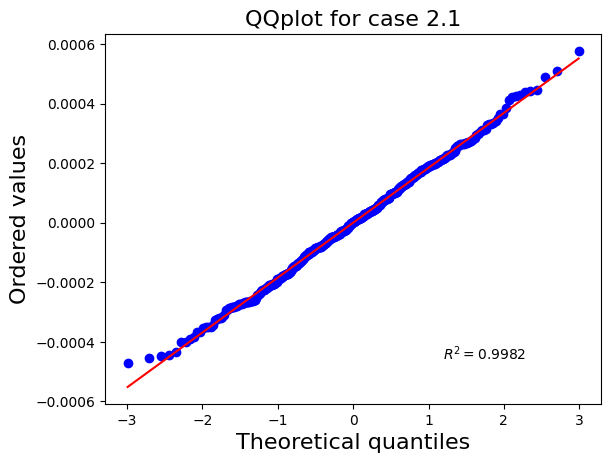

In [3]:
import matplotlib.pyplot as plt
from scipy import stats
stats.probplot(para_mat.reshape(-1) - np.mean(para_mat.reshape(-1)), dist=stats.norm, plot=plt,rvalue=True)   
plt.title('QQplot for case 2.1',fontsize=16)
plt.xlabel('Theoretical quantiles',fontsize=16)
plt.ylabel('Ordered values',fontsize=16)
plt.show()
# plt.savefig('pic/GFN_qqplot_1.png')

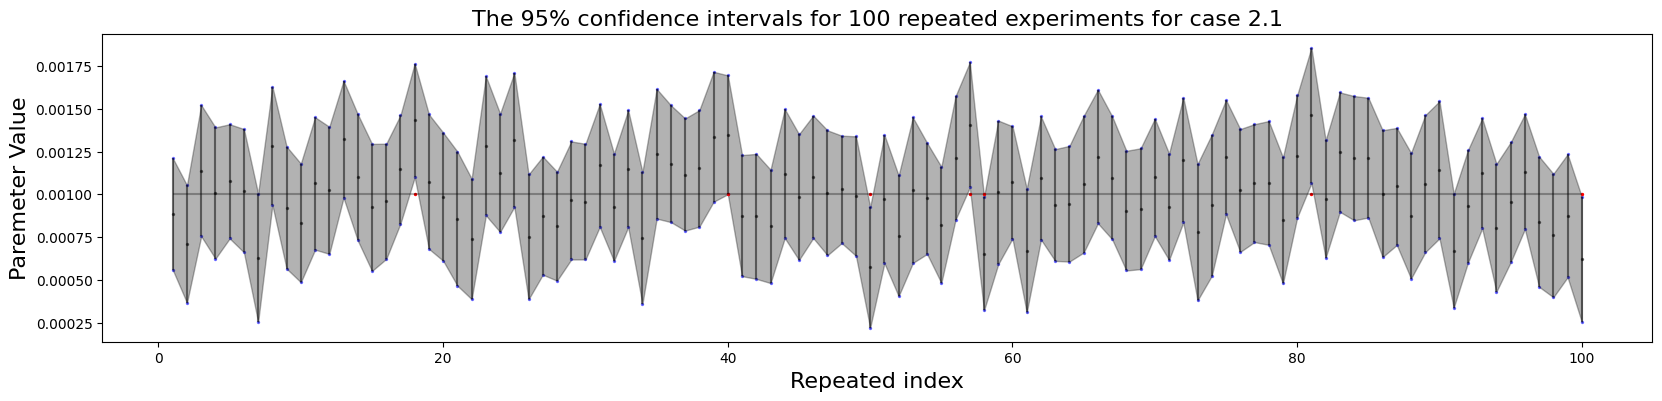

In [5]:
y = para_mat.reshape(-1)[0:100]
x = np.array(range(1,101))
theta0 = 1e-3
plt.figure(figsize=(20,4))
plt.scatter(x,y,s=2,alpha=0.5,color='black')
plt.hlines(y=theta0,xmin=1,xmax=100,linestyles='solid',colors='black',alpha=0.3)
# 90 % confidence interval
sigma = sigma_list.reshape(-1)[0:100]
# y_up_90 = y + sigma * 1.645  
# y_down_90 = y - sigma * 1.645
# plt.fill_between(x,y_down_90,y_up_90,alpha = 0.1,color = 'c')
# 80 % confidence interval
# y_up_80 = y + sigma * 1.28
# y_down_80 = y - sigma * 1.28
# plt.scatter(x,y_down_80,s=2,alpha=0.5,color='r')
# plt.scatter(x,y_up_80,s=2,alpha=0.5,color='r')
# plt.vlines(x,ymin=y_down_80,ymax = y_up_80,linestyles='solid',colors='b',alpha=0.3)
# plt.fill_between(x,y_down_80,y_up_80,alpha = 0.3,color = 'k')
# y_up_95 = y + sigma * 1.96
# y_down_95 = y - sigma * 1.96
# plt.fill_between(x,y_down_95,y_down_80,alpha = 0.5,color = 'k')
# plt.fill_between(x,y_up_80,y_up_95,alpha = 0.5,color = 'k')
y_up_95 = y + sigma * 1.96
y_down_95 = y - sigma * 1.96
plt.scatter(x,y_down_95,s=2,alpha=0.5,color='b')
plt.scatter(x,y_up_95,s=2,alpha=0.5,color='b')
plt.vlines(x,ymin=y_down_95,ymax = y_up_95,linestyles='solid',colors='k',alpha=0.5)
plt.fill_between(x,y_down_95,y_up_95,alpha = 0.3,color = 'k')
index_out = (theta0 > y_up_95) + (theta0 < y_down_95)
x_out = x[index_out]
theta0_out = np.ones_like(x_out) * theta0
plt.scatter(x_out,theta0_out,color='r',alpha=1,s=2)
plt.title('The 95% confidence intervals for 100 repeated experiments for case 2.1',fontsize=16)
plt.xlabel('Repeated index',fontsize=16)
plt.ylabel('Paremeter Value',fontsize=16)
plt.show()
# plt.savefig('pic/GFN_confidence_interval1.png')

/tmp/ipykernel_65414/2826517710.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(para_mat-5e-3,hist=False)


<Axes: ylabel='Density'>

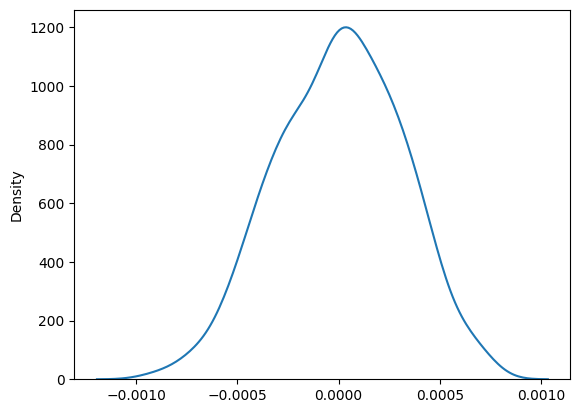

In [8]:
import seaborn as sns
sns.distplot(para_mat-5e-3,hist=False)

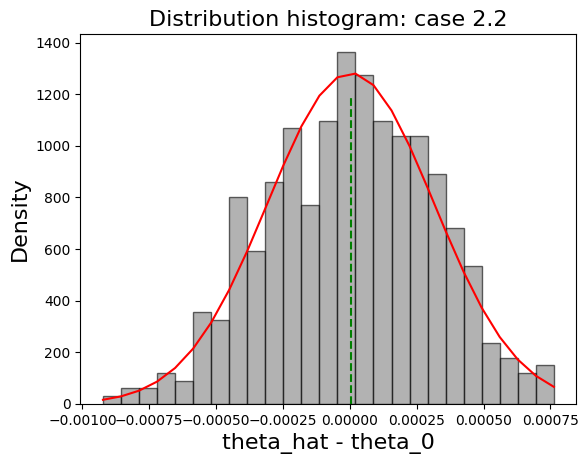

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# plt.rcParams['font.family']='Arial' 
# plt.rcParams['font.size']=15
# plt.figure(figsize=(10,7))
data = (para_mat-5e-3).reshape(-1)
# data = np.random.randn(10000)
mu =np.mean(data) 
sigma =np.std(data) 
num_bins = 25
n, bins, patches = plt.hist(data, num_bins,density=True, edgecolor="black",facecolor='gray',
                            alpha=0.6)
y = norm.pdf(bins, mu, sigma) 
plt.plot(bins, y, 'r-') 
plt.axvline(x=bias,ls="--",c="green",ymin =0,ymax=0.83)
# plt.xlim((-0.00075,0.00075))
plt.title('Distribution histogram: case 2.2',fontsize=16)
plt.xlabel('theta_hat - theta_0',fontsize=16) 
plt.ylabel('Density',fontsize=16) 
# plt.show()
plt.savefig('pic/GFN_histogram_2.png')